# Вспомнить прошлое

Задание (6 вариант): Декомпозиция ВР вида лин. тренд + НЧ гармоника + ВЧ гармоника.

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import h5py
%matplotlib inline
%config InlineBackend.figure_format ='retina'

## Задание временного ряда

ВР вида линейный тренд: trend = b0+b1*t

In [2]:
def create_linspace(start, stop, nsamples):
    return np.linspace(start, stop, num = nsamples)

def plot(X, t = [], title = '', f_dict = {}):
    """
    f_dict = {
        'functions': [F1, F2, F3],
        'titles': ['function name', 'f name 2']
    }
    """
    plt.figure(figsize = (15, 6))
    plt.title(title)
    if len(t):
        plt.plot(t, X)
    else: plt.plot(X)
    if len(f_dict) > 0:
        legend_labels = []
        for f in f_dict["functions"]:
                if len(t):
                    plt.plot(t, f)
                else: plt.plot(f)
        for label in f_dict["titles"]:
            legend_labels.append(label)
        plt.legend(['Origin', *legend_labels])
    plt.show()

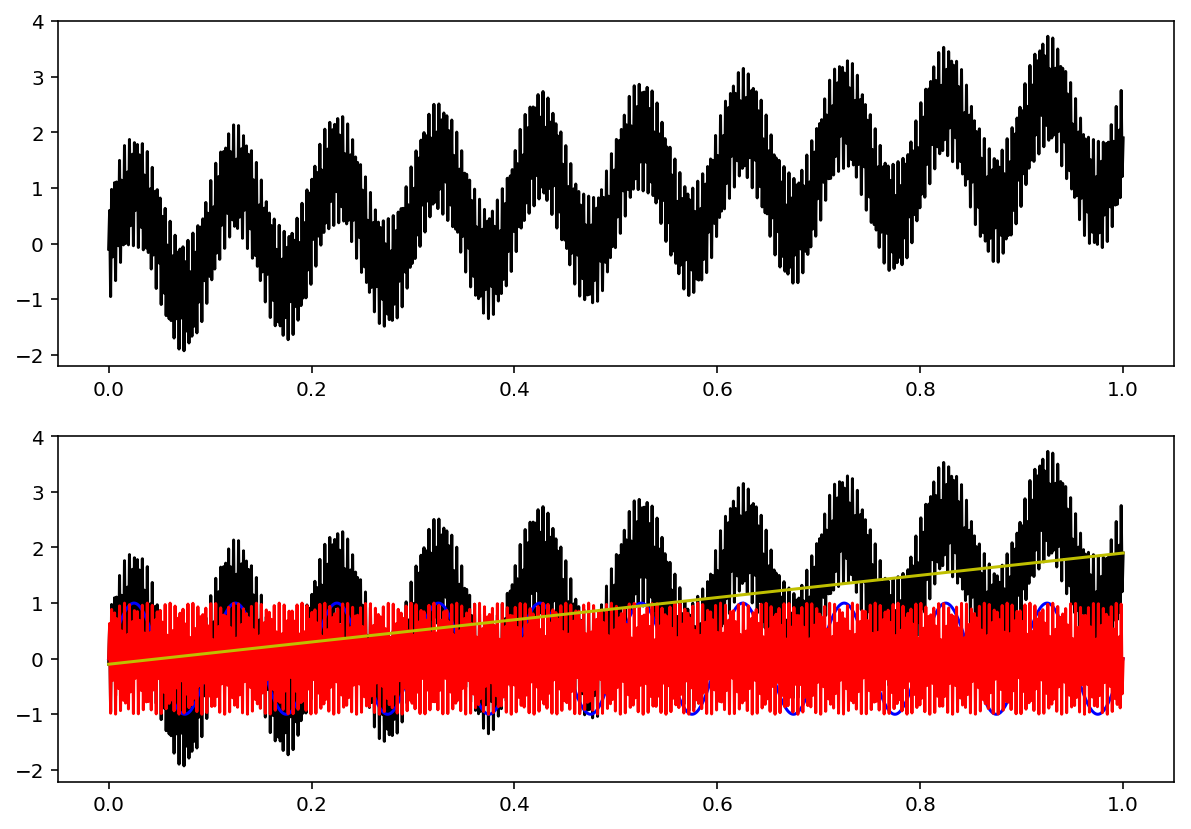

In [35]:
t = create_linspace(0, 1, 1024)

f1 = 10 # НЧ частота
f2 = 400 # ВЧ частота
component1 = np.sin(2*np.pi*f1*t)
component2 = np.sin(2*np.pi*f2*t)
component3 = 2*t - 0.1

F = component1 + component2 + 2*t - 0.1

plt.figure(figsize = (10, 7))
plt.subplot(2,1,1)
plt.plot(t, F, 'k')
plt.subplot(2,1,2)
plt.plot(t, F, 'k')
plt.plot(t, component1, 'b')
plt.plot(t, component2, 'r')
plt.plot(t, component3, 'y')

plt.show()

## 1. Метод Сингулярного Спектрального Анализа SSA

### Декомпозиция ВР

In [26]:
def SSA_modes(F, L):
    """
    Функция для сингулярного разложения временного ряда
    F - Временной ряд, L - Длина окна
    """
    N = len(F)
    K = N - L + 1
    X = np.empty((L, K))
    
    for i in range(0,L):
        for j in range(0,K):
            X[i, j] = F[i + j]

    S = np.dot(X, X.T)
    U, A, _ = np.linalg.svd(S)
    V = np.dot(X.T, U)
    return A, U, V

In [27]:
def SSA_group(A, U, V, N, I):
    """
    Функция для восстановления ряда
    Входные параметры: 
    массив собственных значений A, 
    массив собственных векторов U, 
    массив траекторных векторов V, 
    длина ряда N и массив группировки компонент I.
    """
    L = len(A)
    K = N - L + 1
    V = V.transpose()
    Z = np.dot(U[:, I], V[I, :])

    G = np.zeros(N)
    L_min = min(L,K)
    K_max = max(L,K)
    
    for k in range(N):
        if (0 <= k < L_min - 1):
            sum_Z = Z[0, k]
            
            for m in range(k):
                sum_Z += Z[m, k-m]
            G[k] = 1 / (k + 1) * sum_Z
            
        if (L_min - 1 <= k < K_max):
            sum_Z = Z[0, k]
            
            for m in range(L_min - 1):
                sum_Z += Z[m, k-m]
            G[k] = 1 / L_min * sum_Z
            
        if (K_max <= k < N + 1):
            sum_Z = Z[k - K_max + 1, 0]
            
            for m in range(k - K_max + 1, N - K_max):
                sum_Z += Z[m, k-m]
                
            if (k - K_max + 1 == N - K_max):
                sum_Z = Z[k - K_max + 1, N - K_max]
            G[k] = 1 / (N - k) * sum_Z
            
    return G

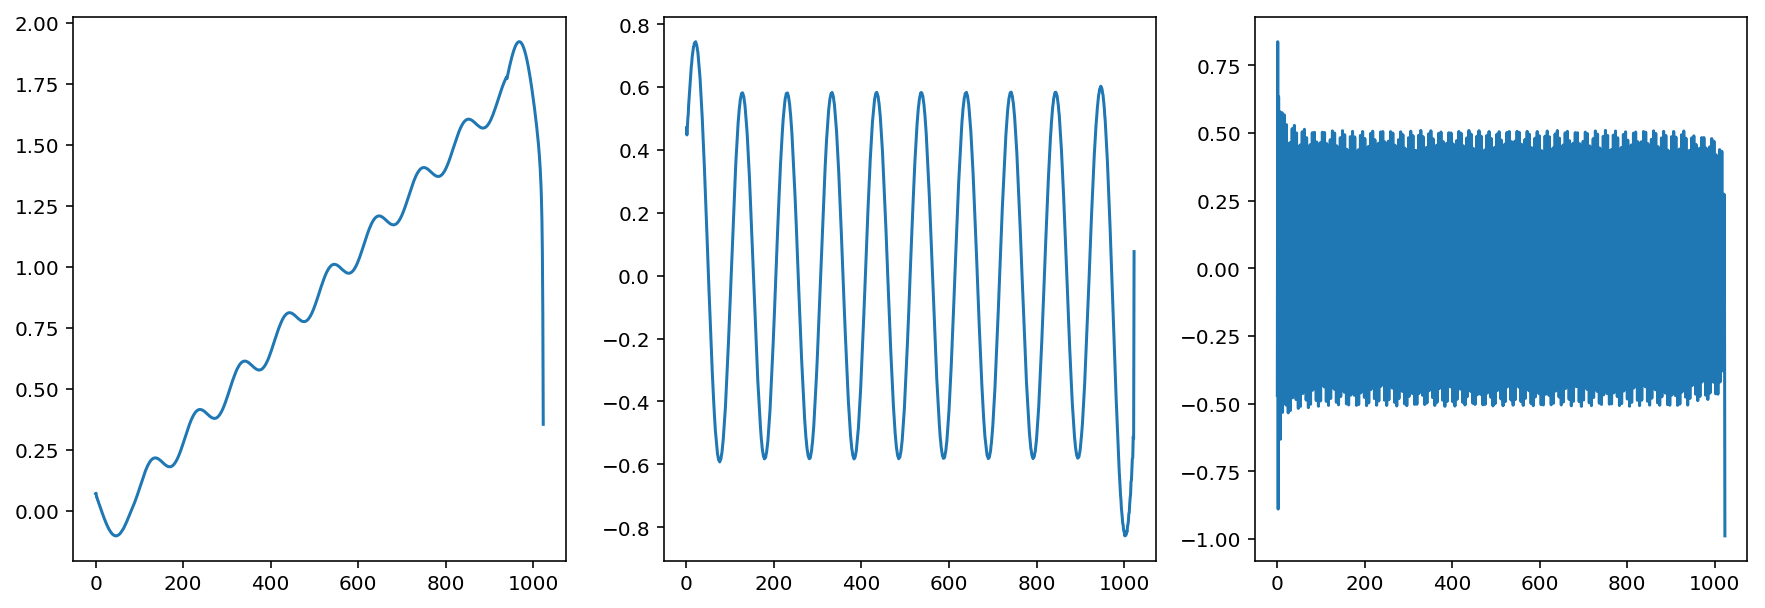

In [28]:
A, U, V = SSA_modes(F, 85)

plt.figure(figsize=(15,5))
F1_1 = SSA_group(A, U, V, len(F),  [0])
plt.subplot(1,3,1)
plt.plot(F1_1)
F1_2 = SSA_group(A, U, V, len(F),  [1])
plt.subplot(1,3,2)
plt.plot(F1_2)
F1_3 = SSA_group(A, U, V, len(F),  [2])
plt.subplot(1,3,3)
plt.plot(F1_3)
plt.show()

### Восстановление по компонентам

<Figure size 720x360 with 0 Axes>

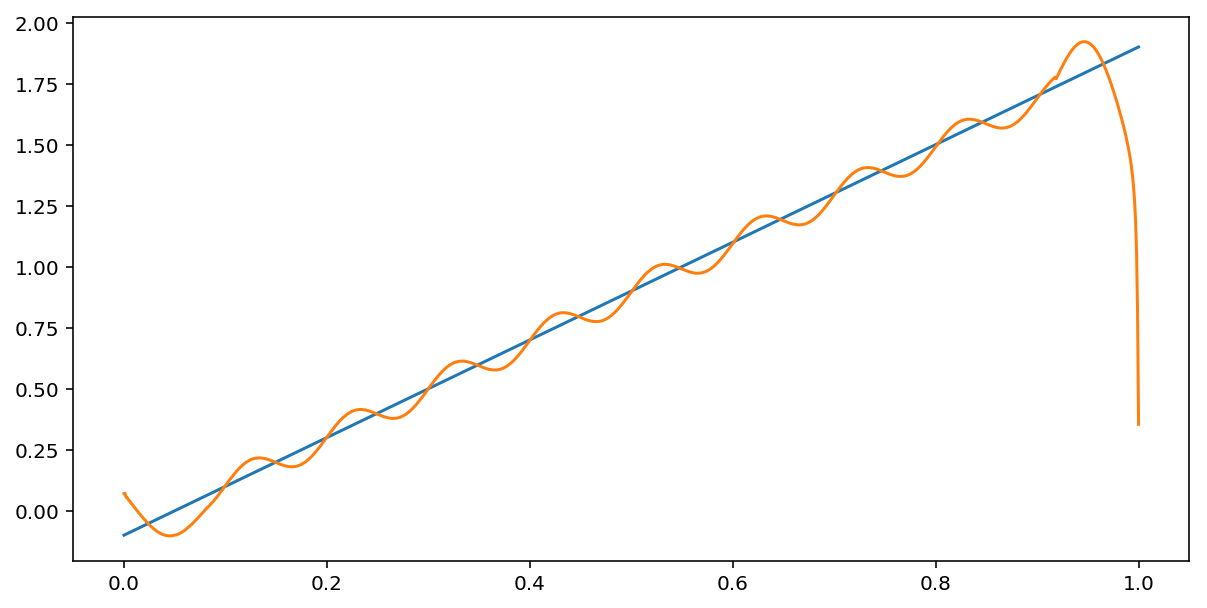

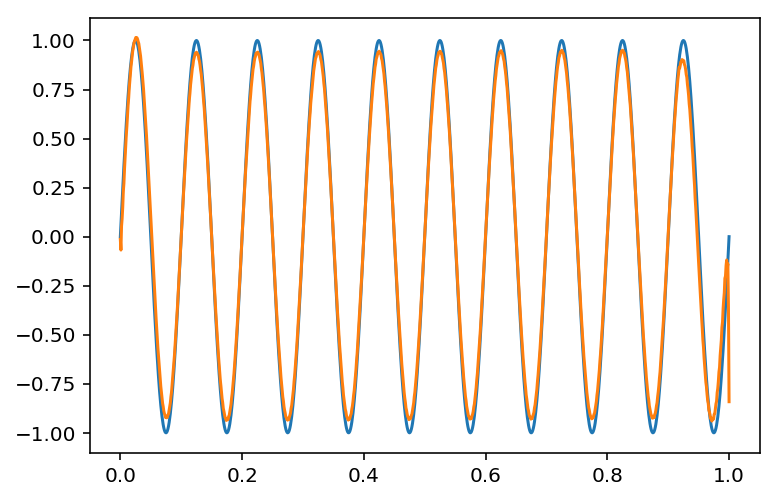

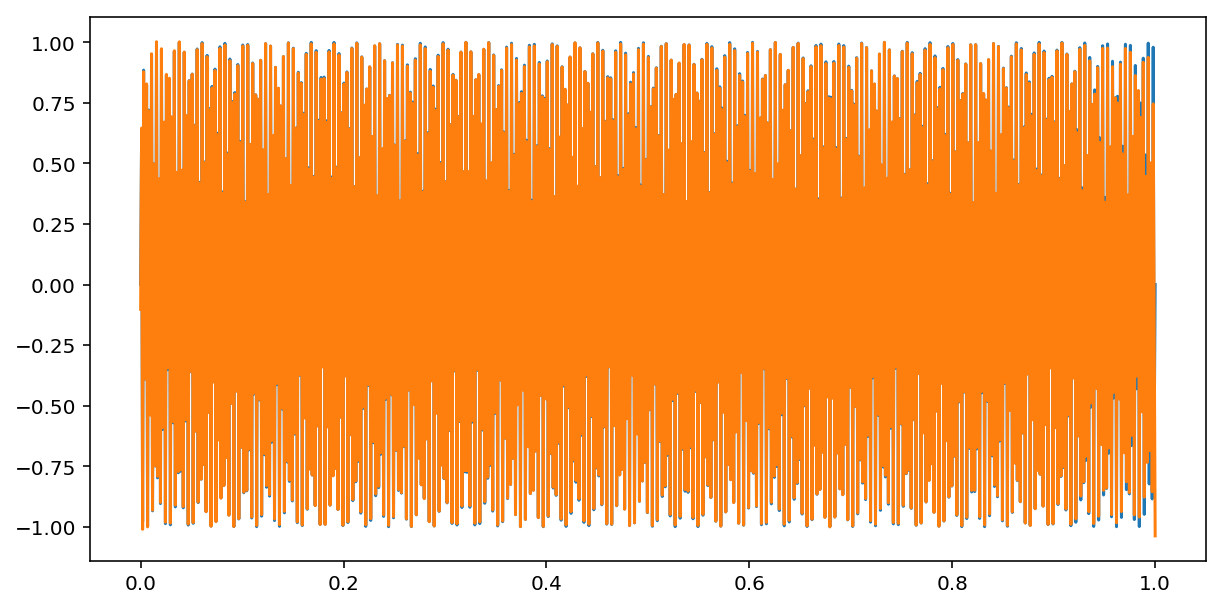

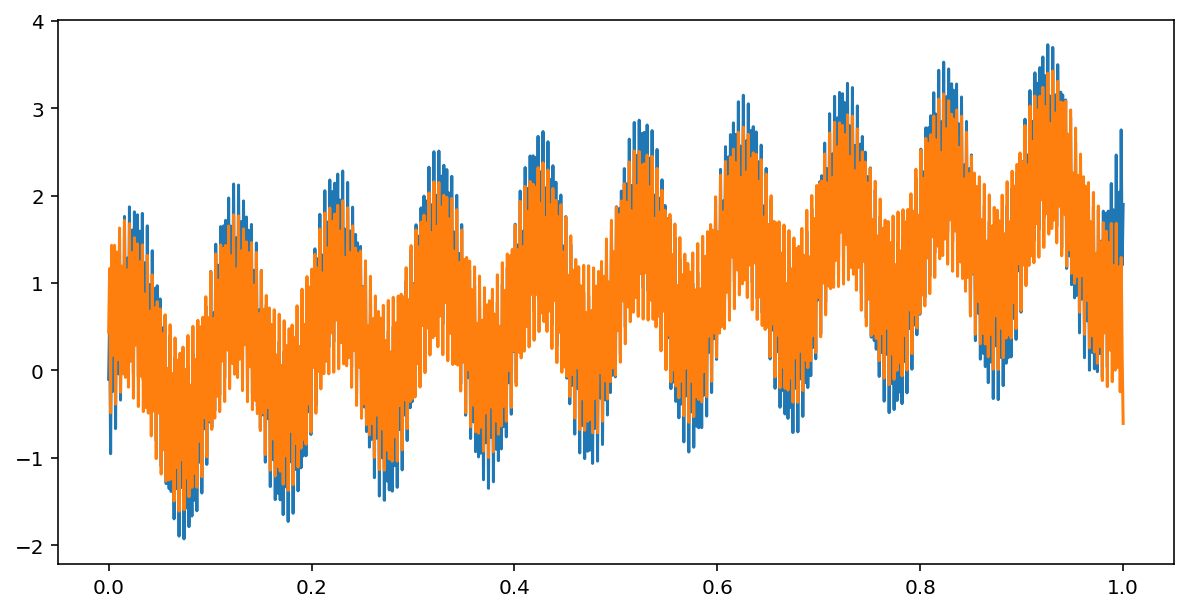

In [29]:
plt.figure(figsize = (10, 5))

plt.figure(figsize = (10, 5))
I = [0]
F1 = SSA_group(A, U, V, len(F), I)
plt.plot(t, component3)
plt.plot(t,F1)
plt.show()

I = [4,1]
F2 = SSA_group(A, U, V, len(F), I)
plt.plot(t, component1)
plt.plot(t,F2)
plt.show()

plt.figure(figsize = (10, 5))
I = [2,3]
F3 = SSA_group(A, U, V, len(F), I)
plt.plot(t, component2)
plt.plot(t,F3)
plt.show()

plt.figure(figsize = (10, 5))
I = [0,1,2,3]
F1 = SSA_group(A, U, V, len(F), I)
plt.plot(t, F)
plt.plot(t,F1)
plt.show()

## 2. Метод Вейвлетной Декомпозиции

### Декомпозиция ВР

In [4]:
import pywt

In [40]:
wvlt_coif5 = pywt.Wavelet('coif5')
wvlt_dmey = pywt.Wavelet('dmey')
(cA5, cD5), (cA4, cD4), (cA3, cD3), (cA2, cD2), (cA1, cD1) = pywt.swt(F, wvlt_dmey, level=5)

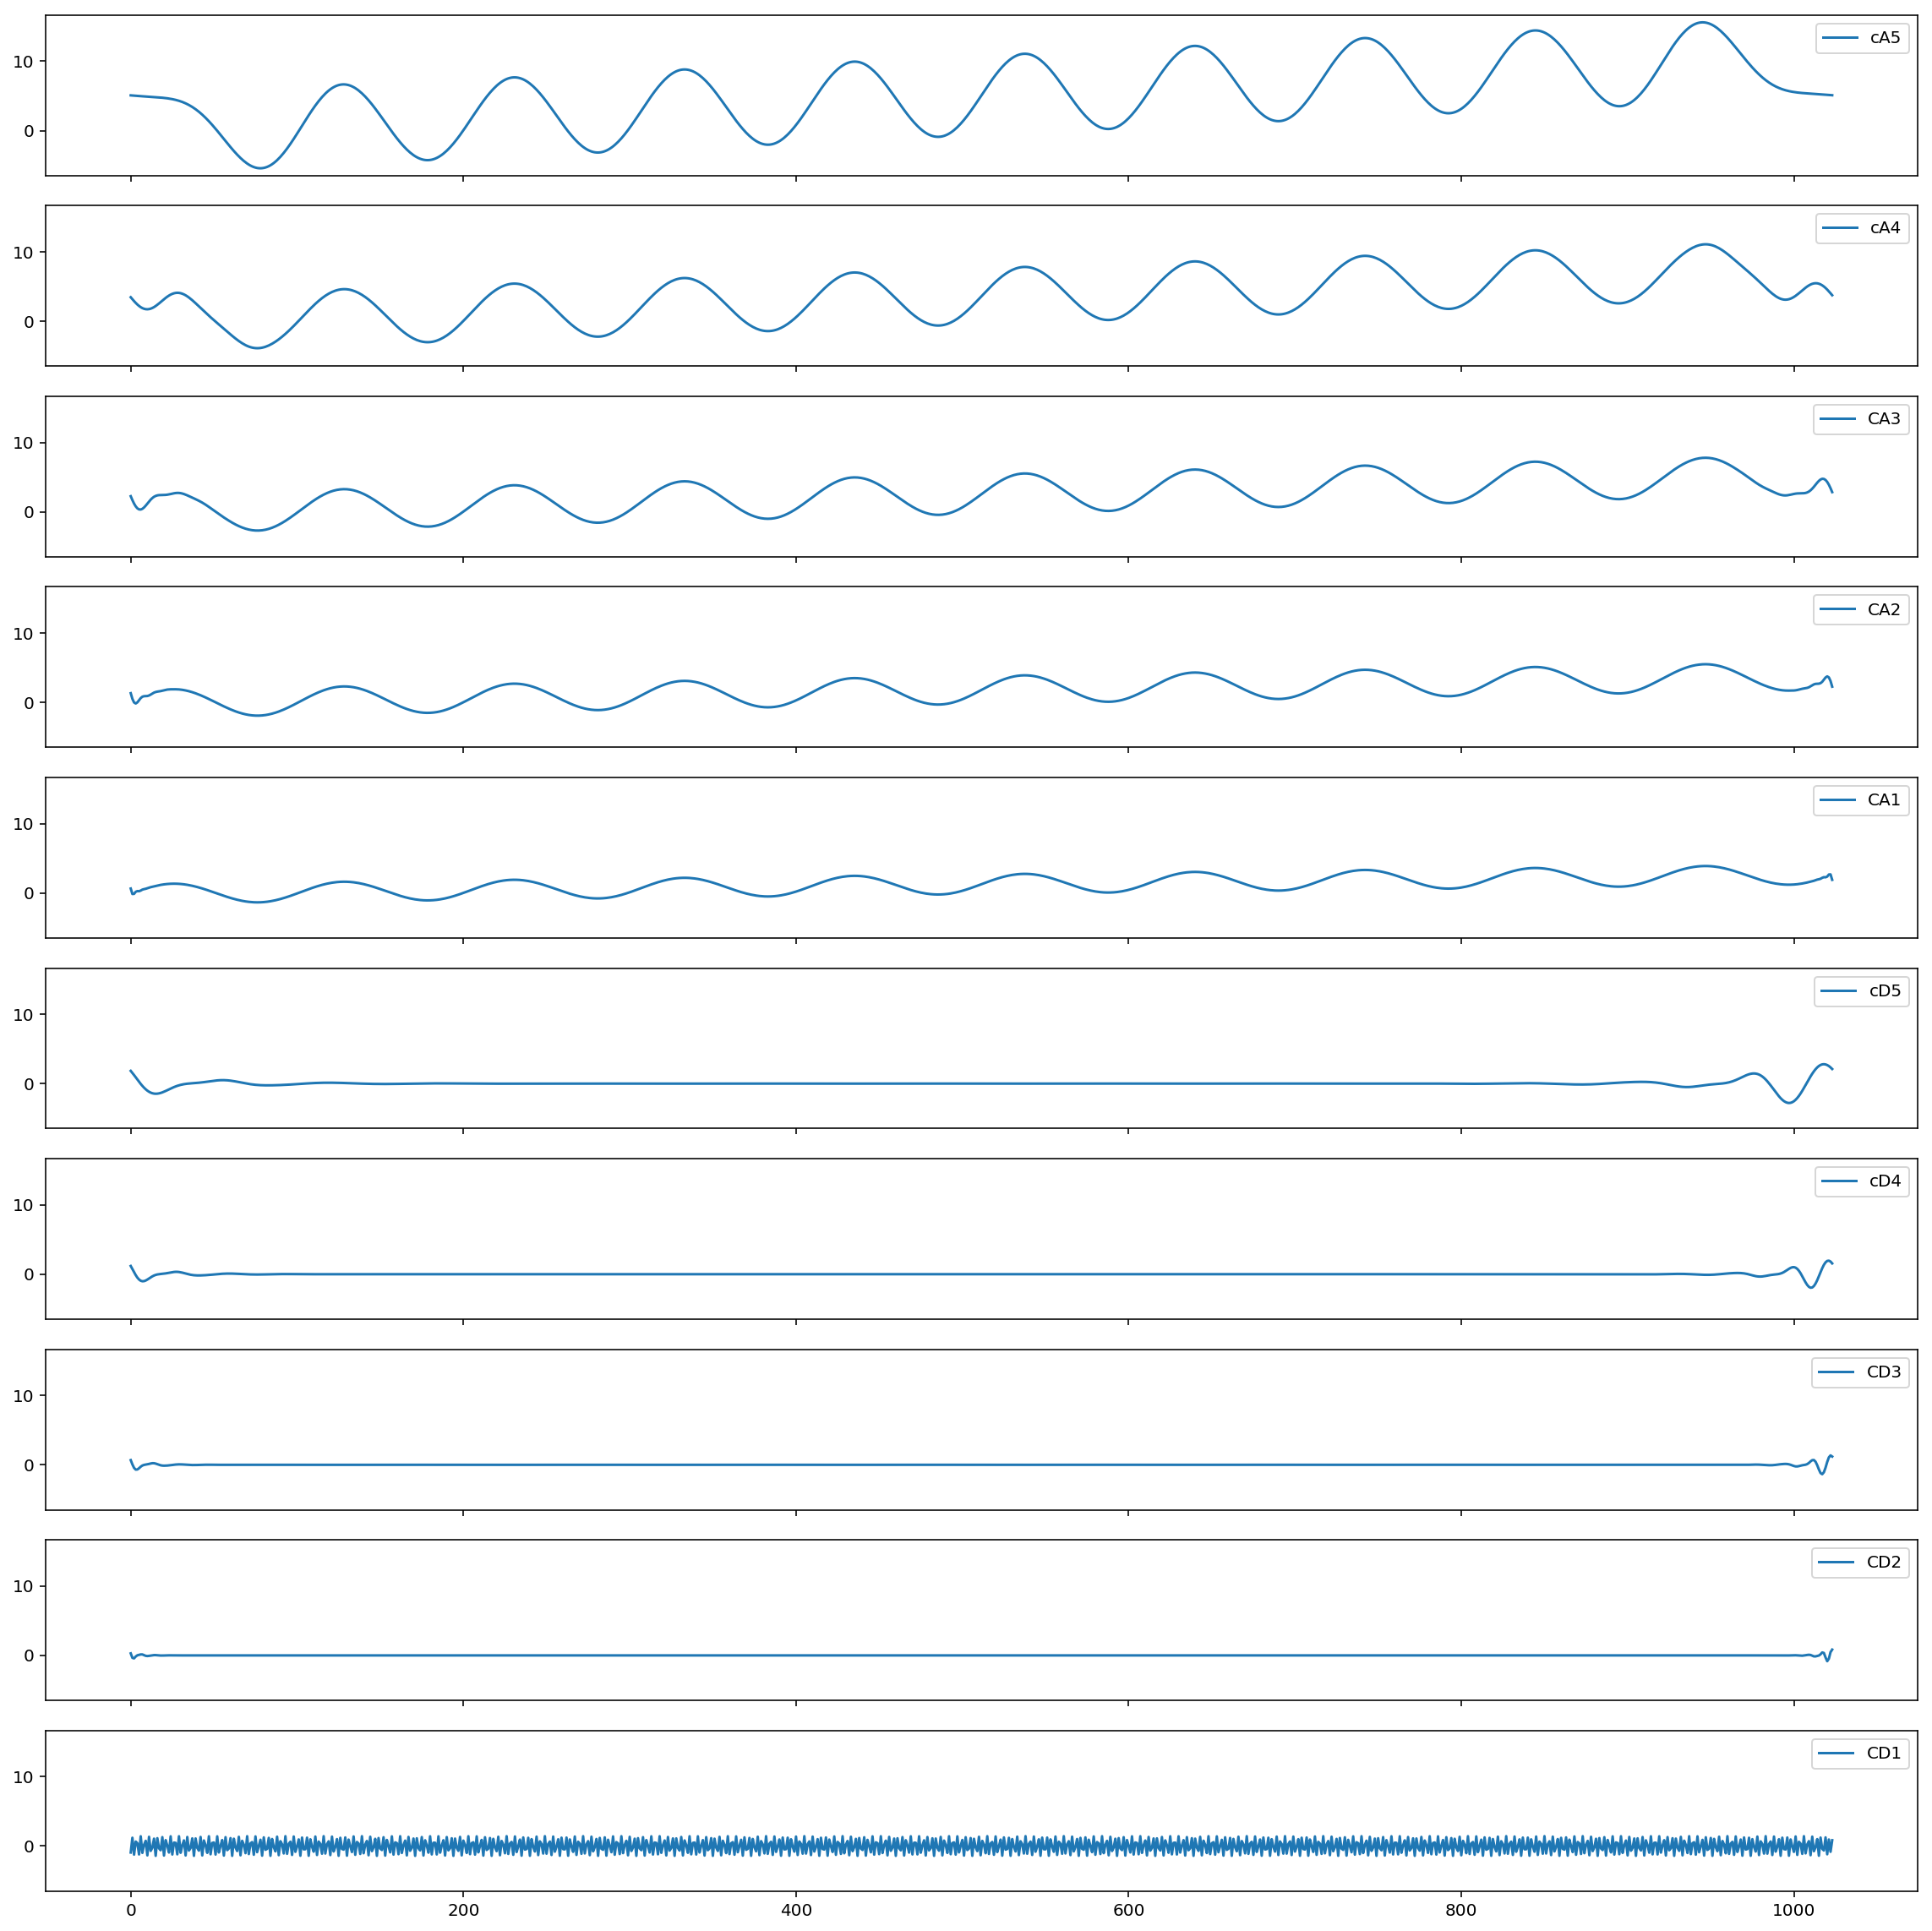

In [57]:
fig, ax = plt.subplots(10, 1, figsize=(16, 16), sharex = True, sharey=True)
ax[0].plot(cA5, label = 'cA5')
ax[1].plot(cA4, label = 'cA4')
ax[2].plot(cA3, label = 'CA3')
ax[3].plot(cA2, label = 'CA2')
ax[4].plot(cA1, label = 'CA1')
ax[5].plot(cD5, label = 'cD5')
ax[6].plot(cD4, label = 'cD4')
ax[7].plot(cD3, label = 'CD3')
ax[8].plot(cD2, label = 'CD2')
ax[9].plot(cD1, label = 'CD1')

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()

plt.tight_layout()
plt.show()

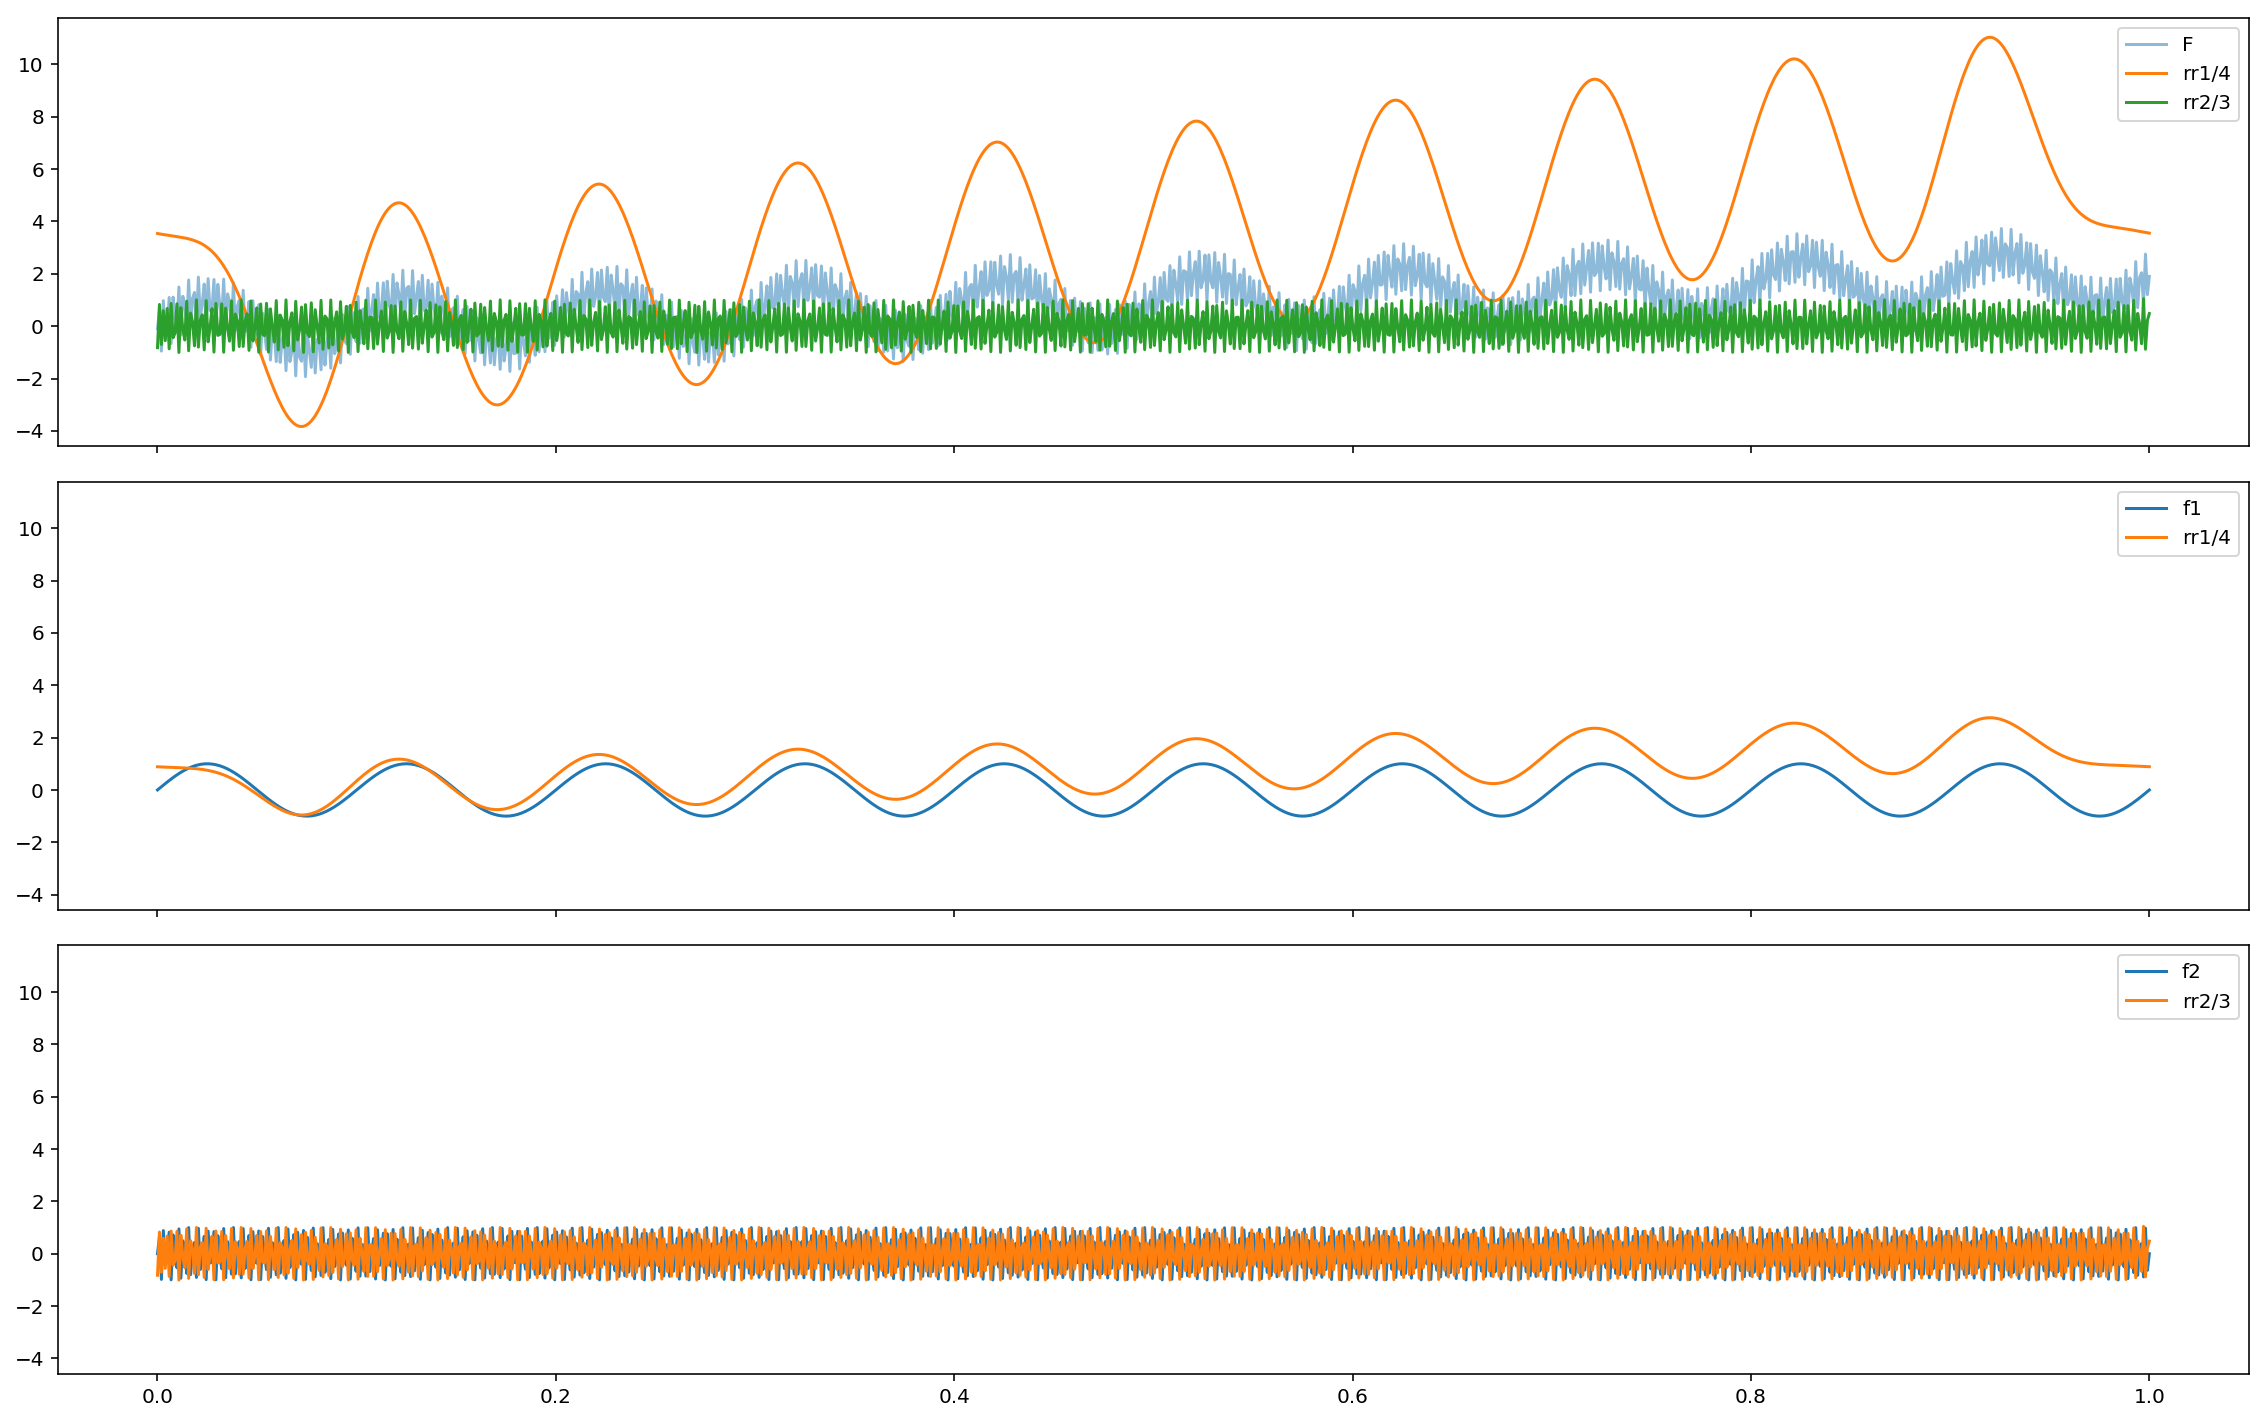

In [71]:
rr1 = pywt.iswt([(cA5, cA2)], wvlt_coif5)
rr2 = pywt.iswt([(cD1, cD1)], wvlt_coif5)

fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex = True, sharey=True)
ax[0].plot(t, F, alpha = 0.5, label = 'F')
ax[0].plot(t, rr1, label = 'rr1/4') # нормируем на уровень 5
ax[0].plot(t, rr2, label = 'rr2/3') # нормируем на уровень 4

ax[1].plot(t, np.sin(2*np.pi*f1*t), label = 'f1')
ax[1].plot(t, rr1/4, label = 'rr1/4')

ax[2].plot(t, np.sin(2*np.pi*f2*t), label = 'f2')
ax[2].plot(t, rr2*1, label = 'rr2/3')

ax[0].legend()
ax[1].legend()
ax[2].legend()

plt.tight_layout()
plt.show()

### Восстановление по компонентам

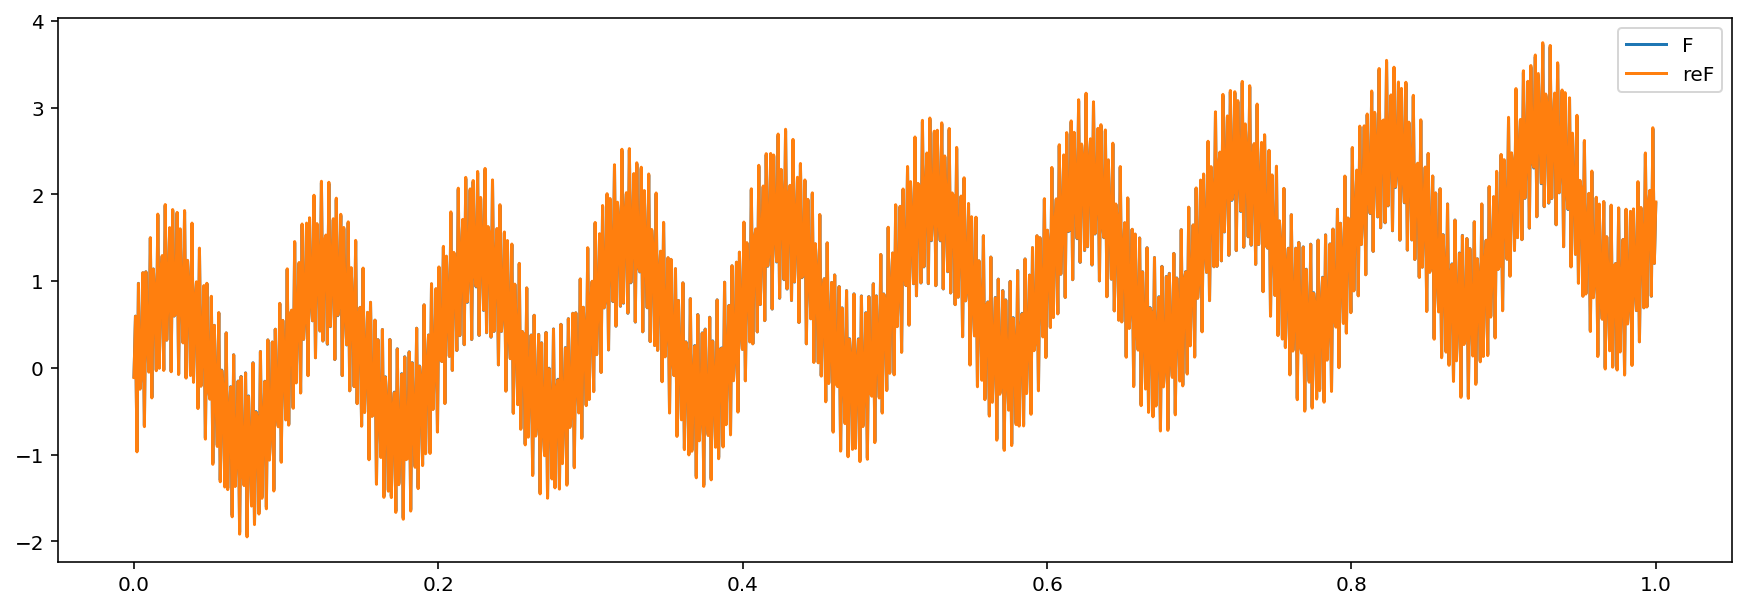

In [58]:
reF = wp.reconstruct() 
plt.figure(figsize = (15, 5))
plt.plot(t, F, label='F')
plt.plot(t, reF, label='reF')

plt.legend()
plt.show()

## 3. Метод Эмпирической Модовой Декомпозиции

In [72]:
from scipy import signal
import scipy

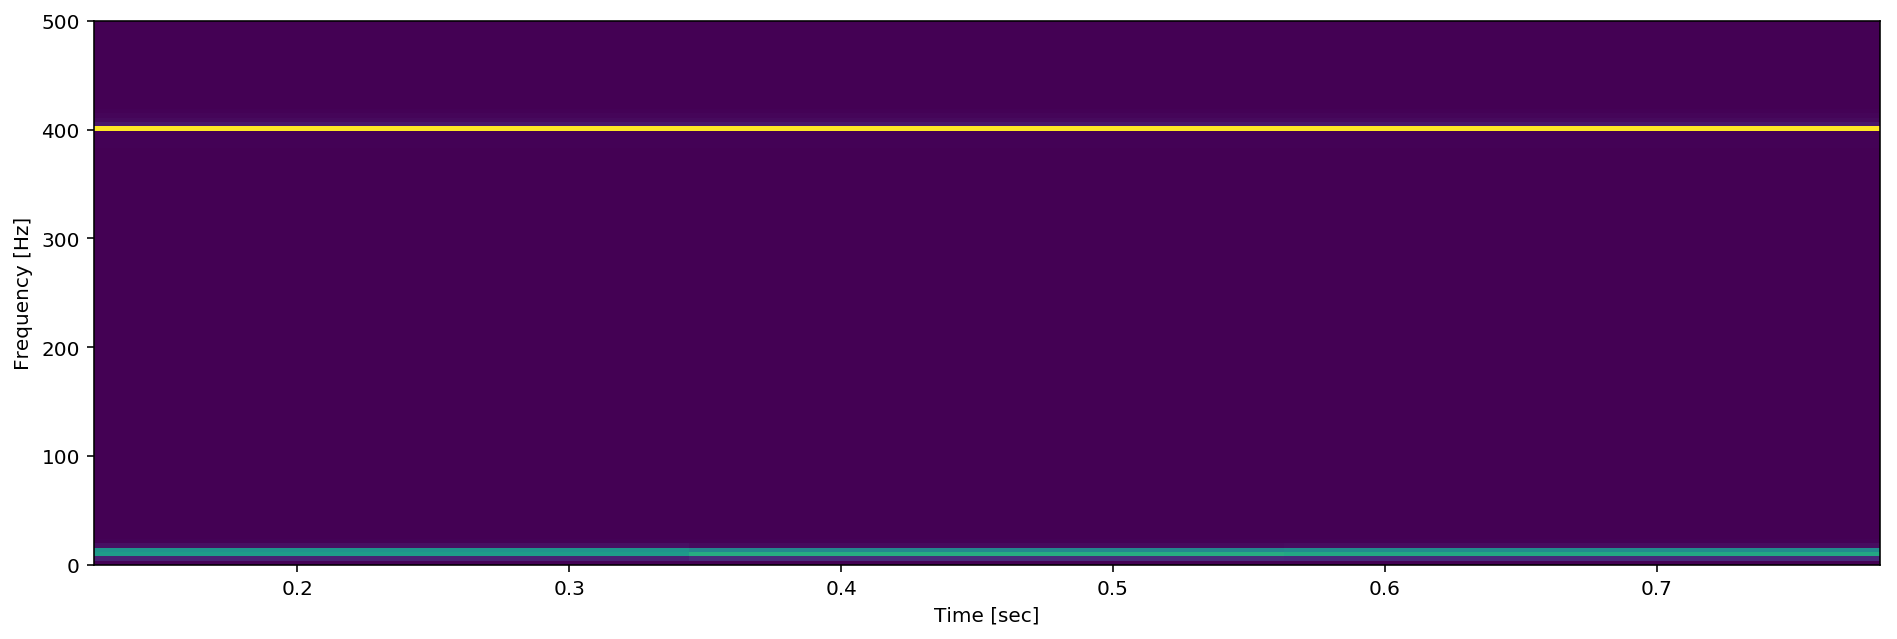

In [82]:
fs = 1/(t[1]-t[0]) 

f, tx, Sxx = signal.spectrogram(F, fs) # возвращаем частоту от времени 
plt.figure(figsize = (16, 5)) 
plt.pcolormesh(tx, f, Sxx) # цвет – интенсивность спектрограммы 
plt.ylabel('Frequency [Hz]') 
plt.ylim(0, 500) 
plt.xlabel('Time [sec]') 
plt.show()

In [121]:
def emd(x, n_components = 1):
    r = x
    t = np.arange(len(r))
    components = np.zeros(n_components, dtype=object)
    r_tmp = r
    for i in range(n_components):
        for j in range(10):
            up_dots = scipy.signal.argrelmax(r_tmp)[0]
            low_dots = scipy.signal.argrelmin(r_tmp)[0]
            
            up_dots_r = r_tmp[up_dots]
            fip = scipy.interpolate.CubicSpline(up_dots,up_dots_r)
            up_dots_t = fip(t)

            low_dots_r = r_tmp[low_dots]
            fitr = scipy.interpolate.CubicSpline(low_dots,low_dots_r)
            low_dots_t = fitr(t)

            mean_t = (up_dots_t + low_dots_t) / 2
            
            samp_start = np.max((np.min(up_dots),np.min(low_dots)))
            samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
            mean_t[:samp_start] = mean_t[samp_start]
            mean_t[samp_end:] = mean_t[samp_end]
            
            r_tmp = r_tmp - mean_t
            
        components[i] = r_tmp
        r_tmp = r-r_tmp
    
    return components

In [144]:
def emd(x, n_components = 1):
    r = x
    t = np.arange(len(r))
    components = np.zeros(n_components, dtype=object)
    for i in range(n_components):
        r_tmp = r
        for j in range(10):
            up_dots = scipy.signal.argrelmax(r_tmp)[0]
            low_dots = scipy.signal.argrelmin(r_tmp)[0]
            
            up_dots_r = r_tmp[up_dots]
            fip = scipy.interpolate.CubicSpline(up_dots,up_dots_r)
            up_dots_t = fip(t)

            low_dots_r = r_tmp[low_dots]
            fitr = scipy.interpolate.CubicSpline(low_dots,low_dots_r)
            low_dots_t = fitr(t)

            mean_t = (up_dots_t + low_dots_t) / 2
            
            samp_start = np.max((np.min(up_dots),np.min(low_dots)))
            samp_end = np.min((np.max(up_dots),np.max(low_dots))) + 1
            mean_t[:samp_start] = mean_t[samp_start]
            mean_t[samp_end:] = mean_t[samp_end]
            
            r_tmp = r_tmp - mean_t
        
        components[i] = r_tmp
        r = r - components[i] 
    
    return components

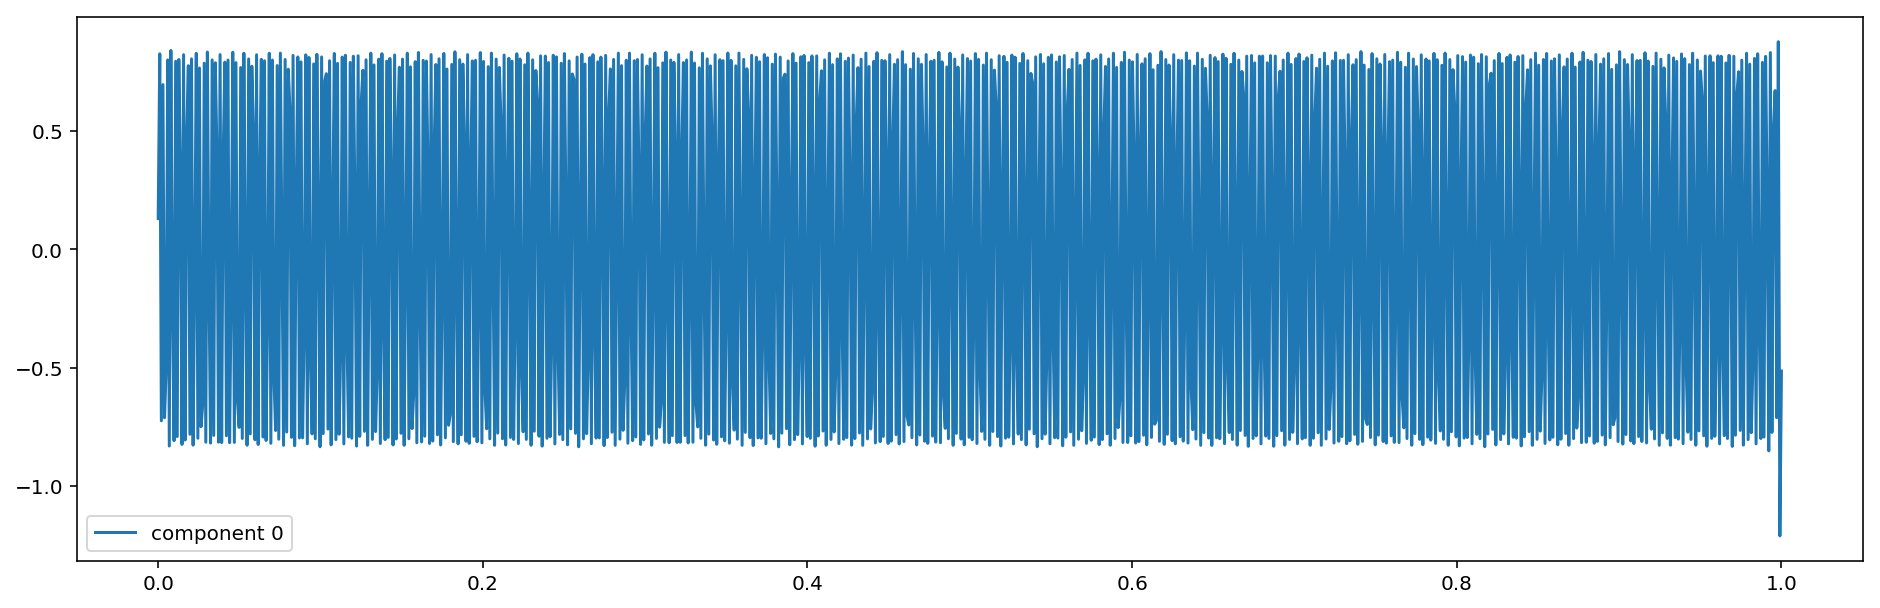

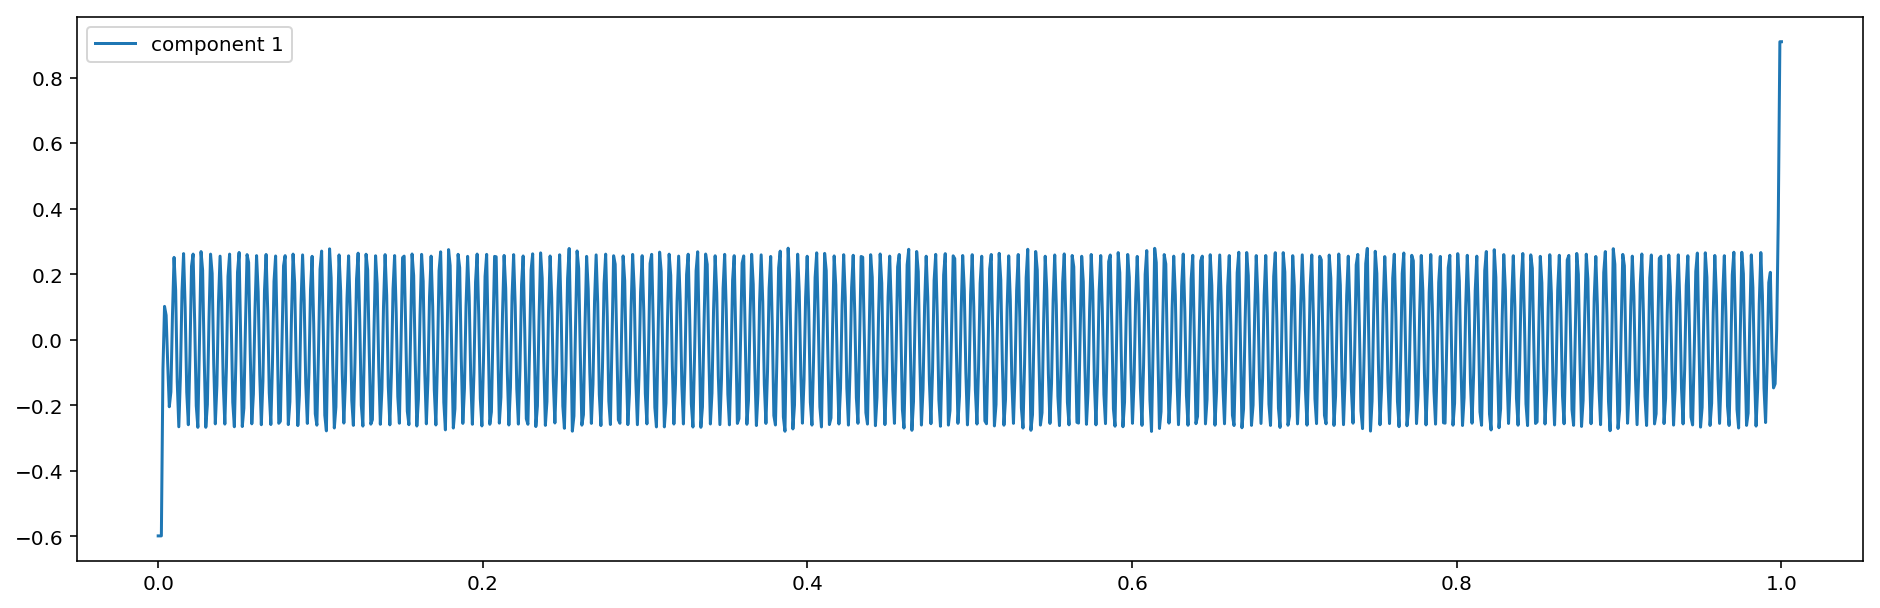

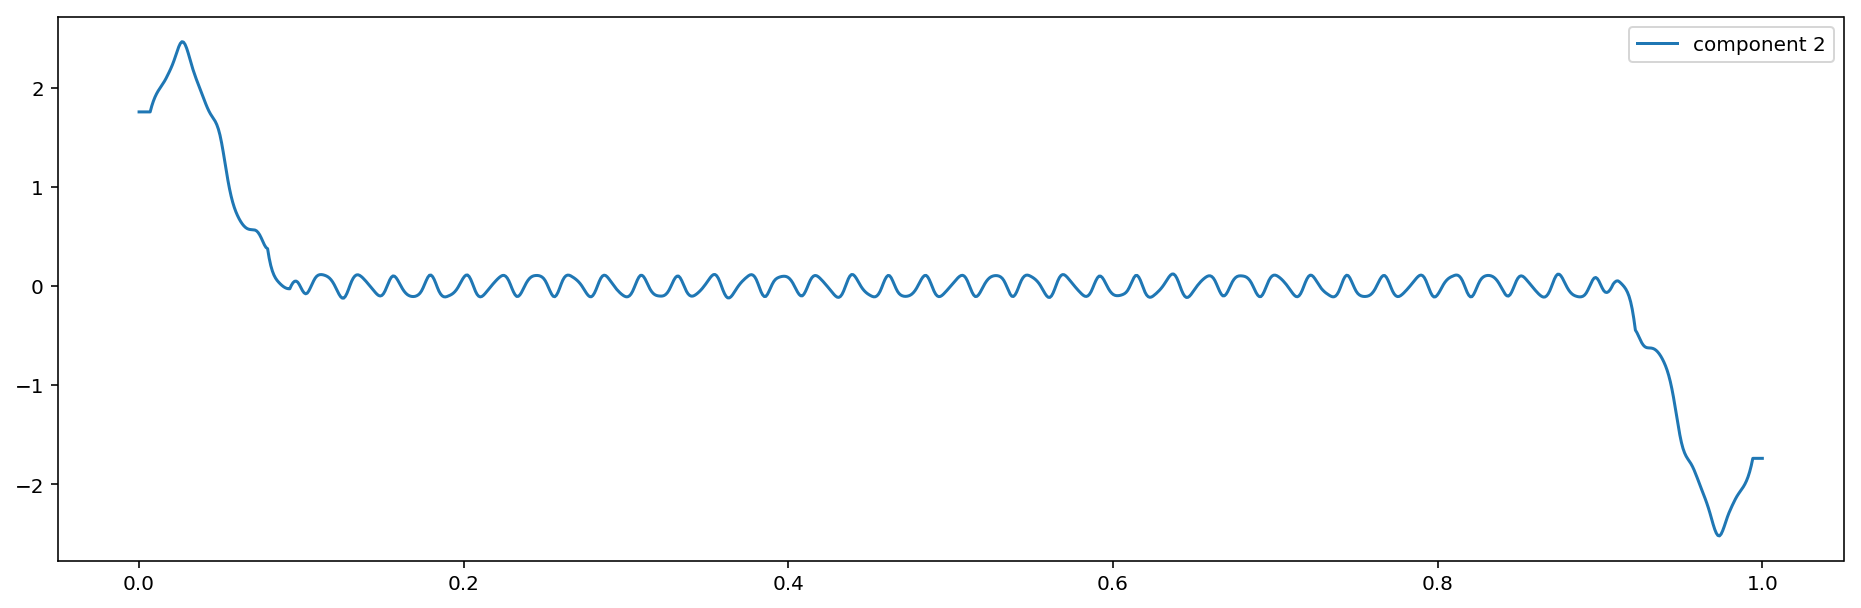

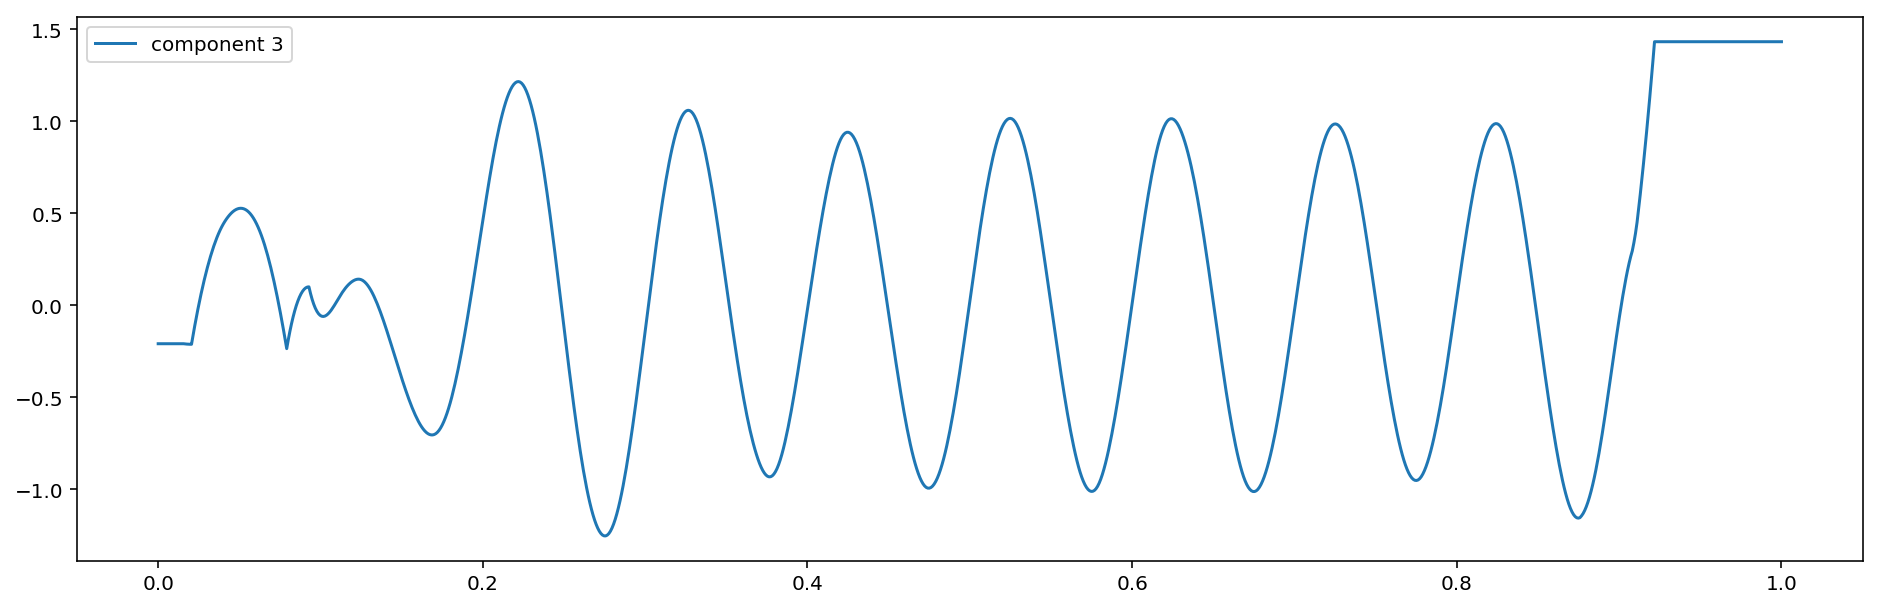

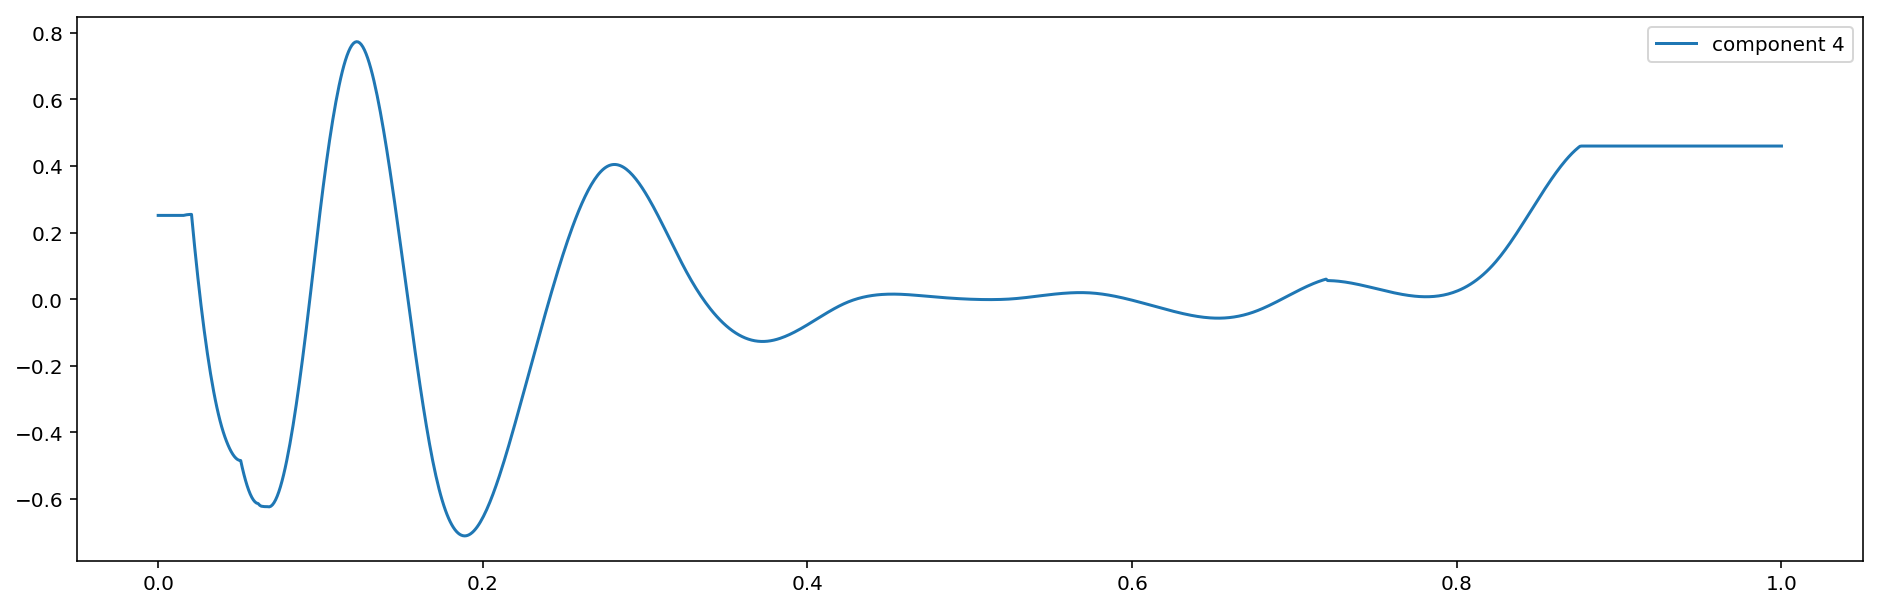

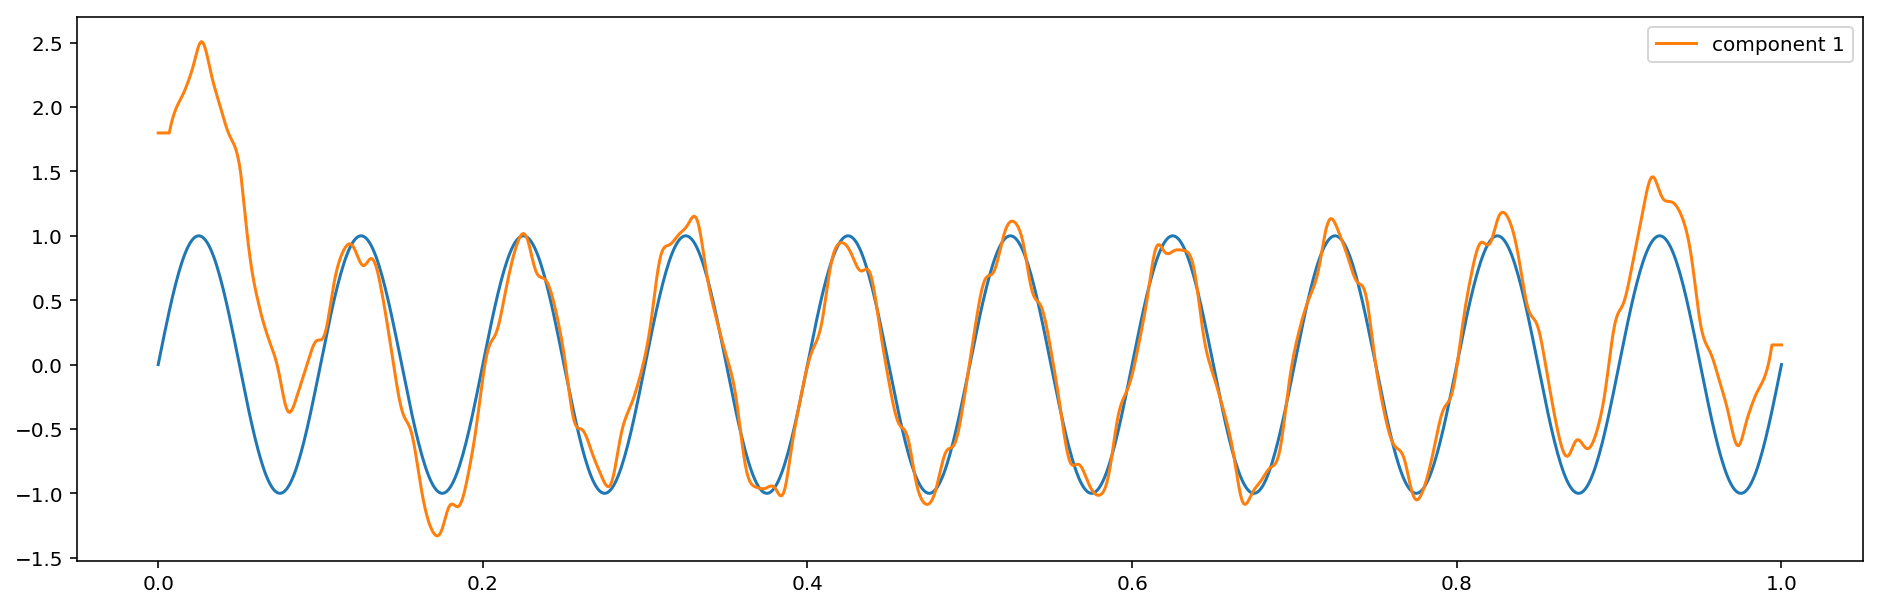

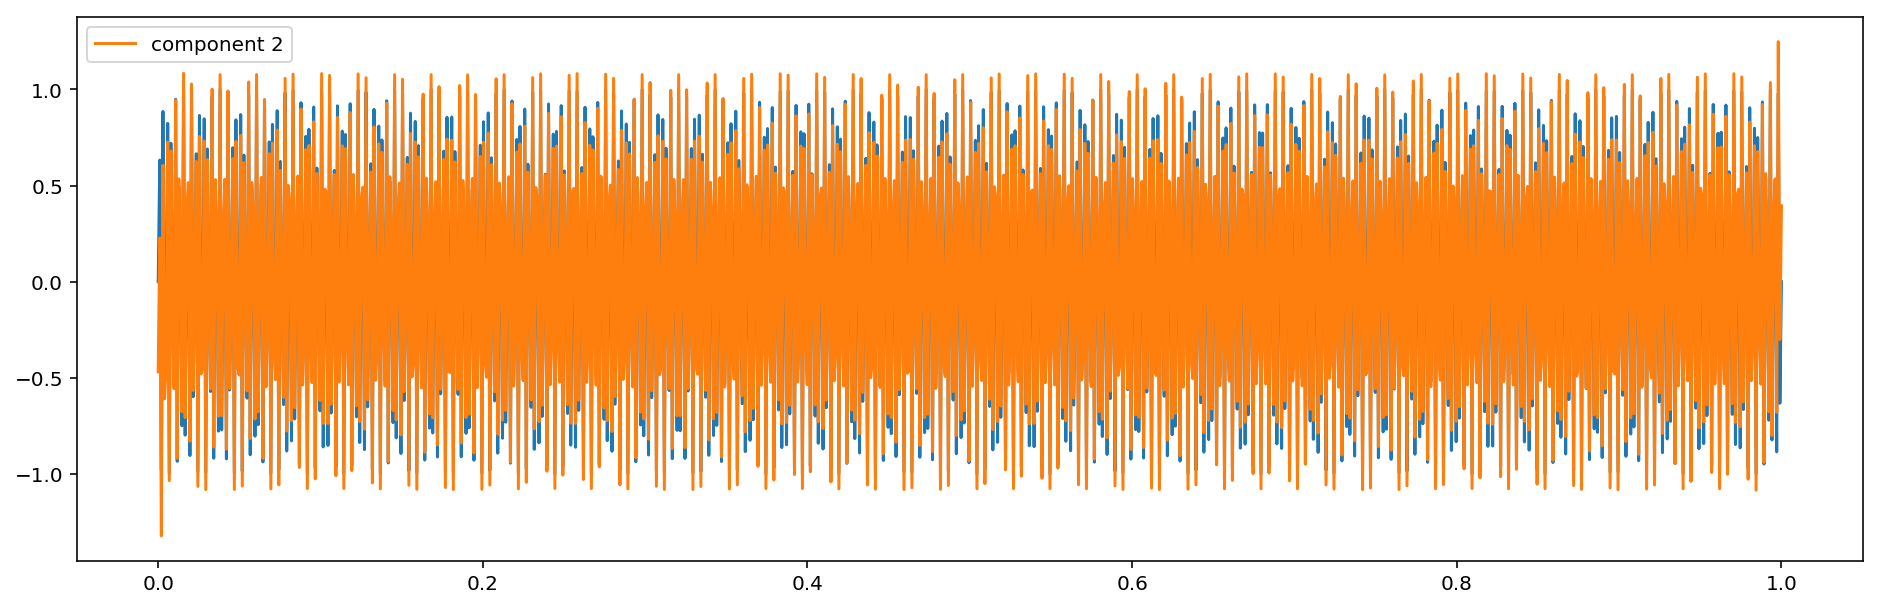

In [150]:
componentsCount = 5

emd_results = emd(F,componentsCount)

for i in range(componentsCount):
    plt.figure(figsize = (16, 5))
    plt.plot(t, emd_results[i], label='component {0}'.format(i))
    plt.legend()
    plt.show()

plt.figure(figsize = (16, 5))
plt.plot(t, component1)
plt.plot(t, emd_results[3] + emd_results[4] + emd_results[2], label='component 1')
plt.legend()
plt.show()

plt.figure(figsize = (16, 5))
plt.plot(t, component2)
plt.plot(t, emd_results[0] + emd_results[1], label='component 2')
plt.legend()
plt.show()

# plt.figure(figsize = (16, 5))
# plt.plot(t, component3)
# plt.plot(t, emd_results[2], label='component 3')
# plt.legend()
# plt.show()

## Результаты

В результате работы выделили из ВР компоненты